In [1]:
import pandas as pd
import numpy as np

In [2]:
# 주가와 감성 데이터 합치기 (리스크:주가)
senti = pd.read_pickle("../data/daily_sentiment.pickle")
index_ = pd.read_csv("../data//주식한달데이터.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/주식한달데이터.csv'

In [3]:
#종목명 -> 산업 통일 (KRX 제거)
index_['종목명'] = index_['종목명'].str.replace('KRX ', '', regex=False).str.strip()
# 종목명 컬럼 이름 산업으로 변경
index_ = index_.rename(columns={'종목명': 'industry'})
index_
# 날짜 포맷 변경
index_['날짜'] = pd.to_datetime(index_['날짜'], format='%Y%m%d')
index_['날짜'] = index_['날짜'].dt.strftime('%Y-%m-%d')

In [4]:
# 합치기
merged = pd.merge(senti,index_,on=['날짜','industry'],how = 'inner')

# 날짜순 정렬
merged = merged.sort_values(by=['industry', '날짜'])

In [25]:
#  리스크 지수 컬럼 추가
# 일 평균 감정 * ln(1+(산업 기사수 / 전체기사수)) * ln(1+(산업 거래량 / 전체거래량) )
# 1. 일자별 전체 합계 계산 (전체 기사수, 전체 거래량)
total_stats = merged.groupby('날짜').agg({
    '본문': 'sum',
    '거래량(천주)': 'sum'
}).rename(columns={'본문': 'Total_News', '거래량(천주)': 'Total_Volume'})

# 2. 데이터 병합
risk_data = merged.merge(total_stats, on='날짜')

# 3. 날짜 정렬
risk_data = risk_data.sort_values(by=['industry', '날짜']).reset_index(drop=True)

# 4. 리스크 지수(Risk_Index) 계산
# 분모가 0이 되는 것을 방지하기 위해 +1 처리가 된 ln(1+x) 구조 활용
risk_data['Risk_Index'] = (
    risk_data['Ave_sentiment'] * np.log1p(risk_data['본문'] / risk_data['Total_News']) * np.log1p(risk_data['거래량(천주)'] / risk_data['Total_Volume'])
)

# 5. 새로운 변수로 학습 진행
features = ['Risk_Index', '종가(백만원)', 'Ave_sentiment'] # 감성지수와 리스크지수를 같이 넣어 비교
X = risk_data[features]

# 3. 'risk_data' 내부의 데이터를 사용하여 산업별 shift 수행

risk_data['D+1 종가'] = risk_data.groupby('industry')['종가(백만원)'].shift(-1)
risk_data['D+2 종가'] = risk_data.groupby('industry')['종가(백만원)'].shift(-2)

# 4. 상승률 다시 계산
risk_data['D+1 상승률'] = (risk_data['D+1 종가'] - risk_data['종가(백만원)']) / risk_data['종가(백만원)'] * 100
risk_data['D+2 상승률'] = (risk_data['D+2 종가'] - risk_data['종가(백만원)']) / risk_data['종가(백만원)'] * 100


risk_data

,날짜,Ave_sentiment,본문,industry,종가(백만원),거래량(천주),Total_News,Total_Volume,Risk_Index,D+1 종가,D+2 종가,D+1 상승률,D+2 상승률
0,2025-12-01,0.771734,199,건설,776.06,17355,792,58393,0.045014,785.34,809.35,1.195784,4.289617
1,2025-12-02,0.751509,95,건설,785.34,9244,564,58742,0.017097,809.35,799.81,3.057275,1.842514
2,2025-12-03,0.762538,126,건설,809.35,22793,592,71861,0.040537,799.81,836.32,-1.178724,3.332304
3,2025-12-04,0.844204,116,건설,799.81,17858,722,69639,0.028713,836.32,822.35,4.564834,2.818169
4,2025-12-05,0.757983,73,건설,836.32,22471,473,89752,0.024307,822.35,815.10,-1.670413,-2.537306
5,2025-12-08,0.829291,91,건설,822.35,29733,631,80755,0.035023,815.10,812.28,-0.881620,-1.224539
6,2025-12-09,0.802617,131,건설,815.10,22556,630,65766,0.044712,812.28,831.19,-0.345970,1.973991
7,2025-12-10,0.708807,99,건설,812.28,13778,545,57835,0.025281,831.19,869.81,2.328015,7.082533
8,2025-12-11,0.448070,141,건설,831.19,55445,551,131355,0.035951,869.81,839.68,4.646350,1.021427
9,2025-12-12,0.553226,133,건설,869.81,88902,495,144856,0.063004,839.68,816.94,-3.463975,-6.078339


In [12]:
import pandas as pd
import numpy as np

n = int(input("변동성을 확인할 기준 기간(n일)을 입력하세요: "))

# 1. 원본에서 분석용 DF 생성
df_analysis = risk_data[['날짜', 'industry', 'Risk_Index']].copy()

# 2. 분석용 DF에만 계산 컬럼 추가
# groupby와 transform을 쓰되, 결과만 df_analysis에 저장
group = df_analysis.groupby('industry')['Risk_Index']

df_analysis['MA'] = group.transform(lambda x: x.rolling(window=n).mean())
df_analysis['STD'] = group.transform(lambda x: x.rolling(window=n).std())

# 3. 상/하한선 및 이상치 계산
df_analysis['Upper'] = df_analysis['MA'] + (2 * df_analysis['STD'])
df_analysis['Lower'] = df_analysis['MA'] - (2 * df_analysis['STD'])

# 4. 이상치 판별
df_analysis['Is_Outlier'] = (df_analysis['Risk_Index'] > df_analysis['Upper']) | \
                            (df_analysis['Risk_Index'] < df_analysis['Lower'])

# 5. 이상치만 모은 별도 데이터프레임
outliers = df_analysis[df_analysis['Is_Outlier'] == True].copy()

변동성을 확인할 기준 기간(n일)을 입력하세요: 10


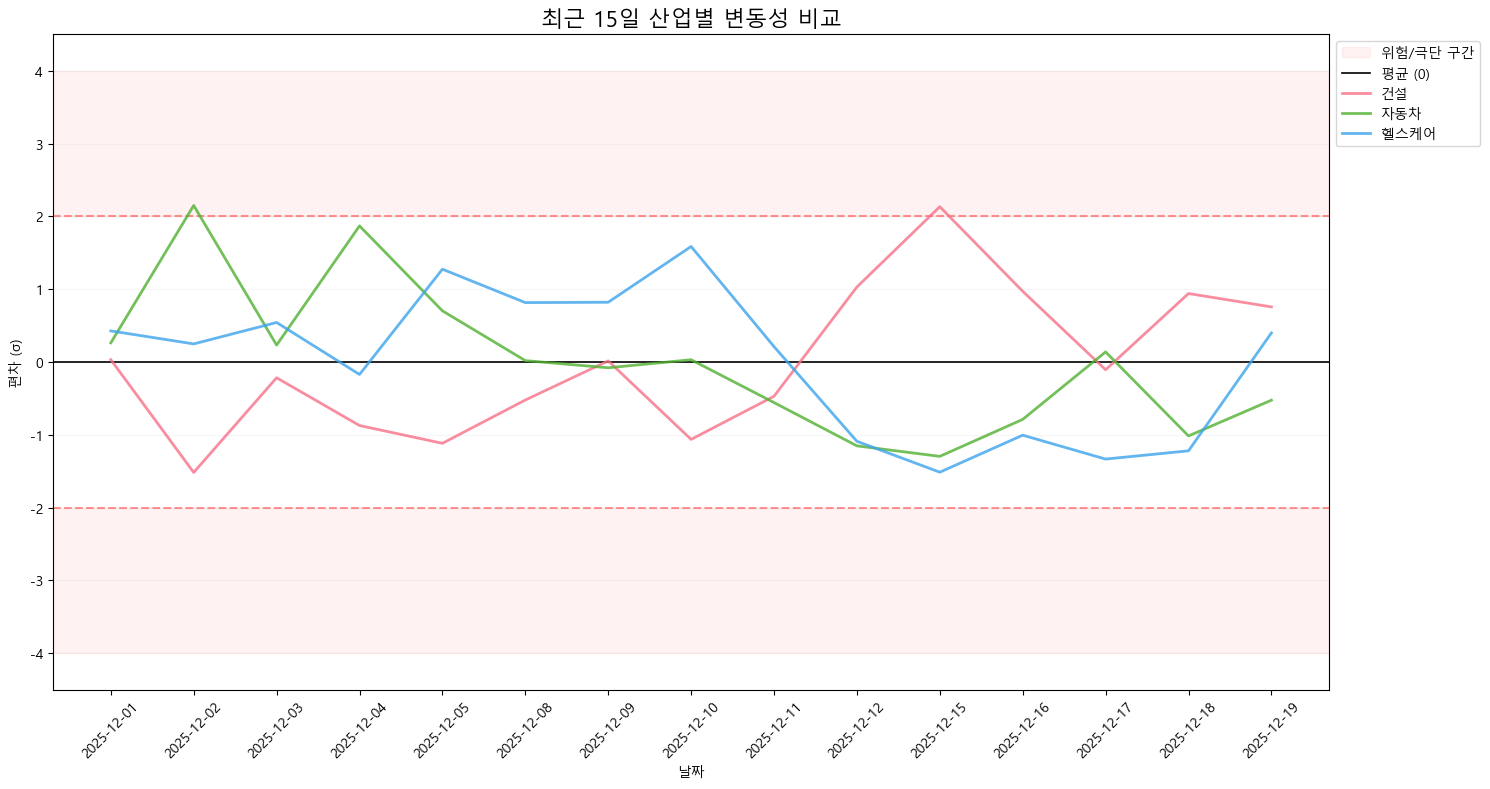

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Z-Score 계산
df_analysis['Z_Score'] = df_analysis.groupby('industry')['Risk_Index'].transform(lambda x: (x - x.mean()) / x.std())

# 1. 폰트 및 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 8))

# 2. 배경 구간 색칠
plt.axhspan(2, 4, color='red', alpha=0.05, label='위험/극단 구간')
plt.axhspan(-4, -2, color='red', alpha=0.05)

# 3. 가이드 수평선
plt.axhline(0, color='black', linewidth=1.2, label='평균 (0)')
plt.axhline(2, color='red', linestyle='--', alpha=0.4)
plt.axhline(-2, color='red', linestyle='--', alpha=0.4)

# 4. 산업별 Z-Score 선 그리기 (최신 n일치만!)
industries = df_analysis['industry'].unique()
colors = sns.color_palette("husl", len(industries))

for i, industry in enumerate(industries):
    # 해당 산업 데이터 필터링 후, 최신 n일치만 tail(n)으로 추출
    df_ind = df_analysis[df_analysis['industry'] == industry].tail(n)
    
    plt.plot(df_ind['날짜'], df_ind['Z_Score'], label=industry, color=colors[i], lw=2, alpha=0.8)

# 5. 그래프 꾸미기
plt.title(f'최근 {n}일 산업별 변동성 비교', fontsize=16)
plt.ylabel('편차 (σ)')
plt.xlabel('날짜')
plt.ylim(-4.5, 4.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, axis='y', alpha=0.1)

# x축 날짜 라벨이 겹치지 않게 회전 (데이터가 많을 경우 대비)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

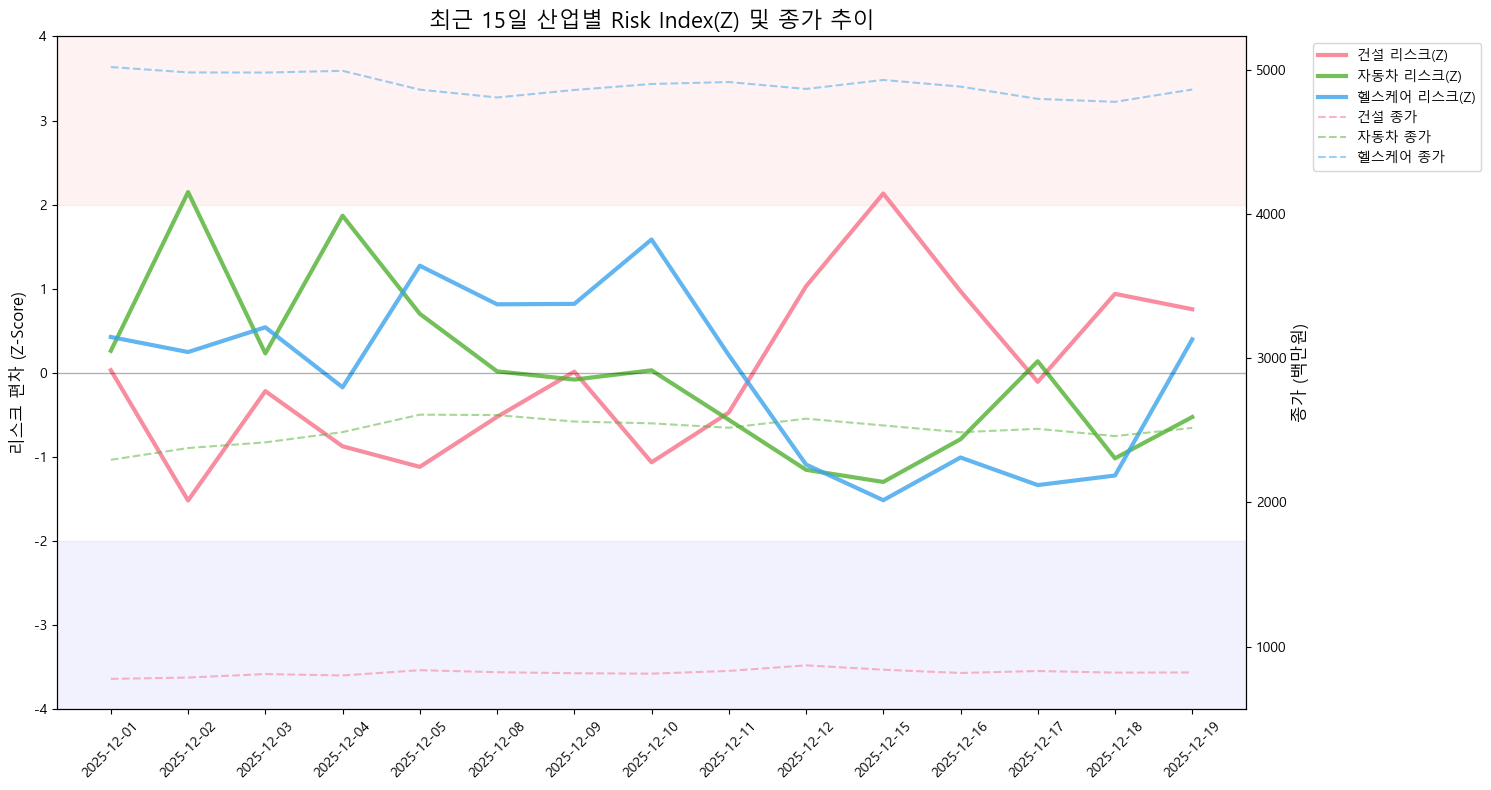

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Z-Score 계산 (risk_data 기준)
risk_data['Z_Score'] = risk_data.groupby('industry')['Risk_Index'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# 2. 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
n = 15  # 최근 15일 데이터 보기

industries = risk_data['industry'].unique()
colors = sns.color_palette("husl", len(industries))

fig, ax1 = plt.subplots(figsize=(15, 8))

# 보조 축 생성 (종가용)
ax2 = ax1.twinx()

for i, industry in enumerate(industries):
    # 해당 산업 데이터 추출
    df_ind = risk_data[risk_data['industry'] == industry].tail(n)
    
    # 왼쪽 축: Z-Score (실선)
    line1 = ax1.plot(df_ind['날짜'], df_ind['Z_Score'], label=f'{industry} 리스크(Z)', 
                     color=colors[i], lw=3, alpha=0.8)
    
    # 오른쪽 축: 종가 (점선)
    line2 = ax2.plot(df_ind['날짜'], df_ind['종가(백만원)'], label=f'{industry} 종가', 
                     color=colors[i], linestyle='--', lw=1.5, alpha=0.5)

# 3. 그래프 꾸미기
ax1.set_ylabel('리스크 편차 (Z-Score)', fontsize=12)
ax1.set_ylim(-4, 4)
ax2.set_ylabel('종가 (백만원)', fontsize=12)

# 가이드 라인 (위험 구간)
ax1.axhspan(2, 4, color='red', alpha=0.05)
ax1.axhspan(-4, -2, color='blue', alpha=0.05)
ax1.axhline(0, color='black', lw=1, alpha=0.3)

plt.title(f'최근 {n}일 산업별 Risk Index(Z) 및 종가 추이', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

# 범례 통합 표시
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

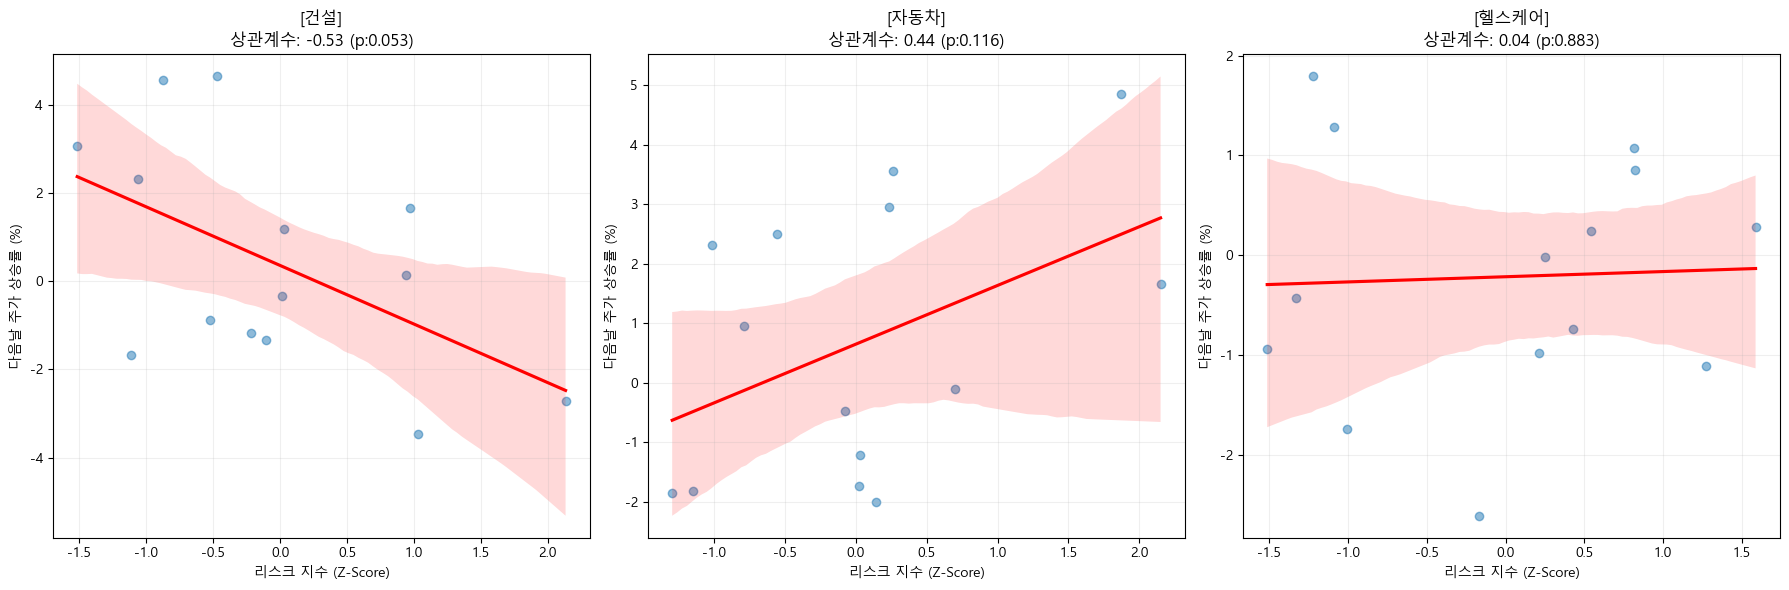

In [22]:
import scipy.stats as stats

# 1. 상관계수 계산 및 시각화
plt.figure(figsize=(18, 6))

for i, industry in enumerate(industries):
    df_ind = risk_data[risk_data['industry'] == industry].dropna(subset=['D+1 상승률', 'Z_Score'])
    
    # 상관계수(Pearson) 계산
    corr, p_value = stats.pearsonr(df_ind['Z_Score'], df_ind['D+1 상승률'])
    
    plt.subplot(1, len(industries), i+1)
    sns.regplot(data=df_ind, x='Z_Score', y='D+1 상승률', 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    plt.title(f'[{industry}]\n상관계수: {corr:.2f} (p:{p_value:.3f})')
    plt.xlabel('리스크 지수 (Z-Score)')
    plt.ylabel('다음날 주가 상승률 (%)')
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [ ]:
# 상관관계가 다양함 ==> 부적합?